# Lecture 2

The first half of this notebook implements the same hierarchical linear regression problem we saw last week.

The second half demonstrates three types of gradient-based inference algorithm run on this model.

## Hierarchical linear regression in `numpyro`

Let's see an initial demonstration of *gradient based inference* using the *probabilistic programming language* `numpyro`.

This demonstration shows linear regression, where we fit several linear datasets simultaneously. *Hierarchical* means that we don't treat the datasets independently, but instead we model the relations between the datasets.

In [1]:
import numpy as np
np.random.seed(301288)
from scipy import stats
import matplotlib.pyplot as plt

## Generate some mock data

Let's make some mock data for $N$ straight lines, where each line $i=1,...,N$ has it's own gradient $m_i$ and slope $c_i$, i.e.

$$
y_{ij} = m_i x_{ij} + c_i
$$

and the gradients and slopes are sampled from normal distributions with specified means $\mu$ and scale $\tau$, i.e.

$$
m_i \sim \mathcal{N}(\mu_m, \tau_m)
$$

$$
c_i \sim \mathcal{N}(\mu_c, \tau_c)
$$

The following function generates this mock data:

In [2]:
def get_data(mu_m = 1.5,
             tau_m = 0.5,
             mu_c = -3.,
             tau_c = 2,
             sig_y = 0.5,
             N = 50,
             n_dat = 30):
    '''generate mock data for N straight lines according to model:
    
    For i = 1, ..., N:
    m_i ~ N(mu_m, tau_m)
    c_i ~ N(mu_c, tau_c)
    For j = 1, ..., n_dat:
        x_{ij} ~ Unif(-3, 3) 
        y^{obs}_{ij} ~ Norm(m_i*x_{ij}+c_i, sig_y)
    
    ''' 
    nrm_m = stats.norm(mu_m, tau_m)
    nrm_c = stats.norm(mu_c, tau_c)
    m = nrm_m.rvs(N)
    c = nrm_c.rvs(N)
    unif_x = stats.uniform(loc=-3, scale=6)
    x = unif_x.rvs((n_dat, N))
    nrm_y_obs = stats.norm(m*x + c, sig_y)
    y_obs = nrm_y_obs.rvs()
    true_pars = {
        'mu_m':mu_m, 
        'tau_m':tau_m, 
        'mu_c':mu_c, 
        'tau_c':tau_c, 
    }
    data = {'N':N, 'n_dat':n_dat, 'x':x, 'y_obs':y_obs, 'sig_y':sig_y}
    return true_pars, data

In [3]:
def plot_data(data, samples=None):
    fig, ax = plt.subplots(5, 10, figsize=(10, 5), sharex=True, sharey=True)
    ax = np.ravel(ax)
    for i, ax0 in enumerate(ax):
        ax0.plot(data['x'][:,i], data['y_obs'][:,i], '.')
        ax0.axhline(0, ls='--', color='k', alpha=0.2)
        ax0.axvline(0, ls='--', color='k', alpha=0.2)
    if samples is not None:
        x = np.linspace(-3,3,100)
        for i, ax0 in enumerate(ax):
            y_smp = samples['m'][:,i]*x[:,np.newaxis] + samples['c'][:,i]
            y_lo, y_hi = np.percentile(y_smp, [0.5,99.5], 1)
            # plt.fill_between(x, y_lo, y_hi, color='C1')
            ax0.plot(x, y_lo, color='C1')
            ax0.plot(x, y_hi, color='C1')
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    return fig

## Look at the data

In [4]:
true_pars, data = get_data()

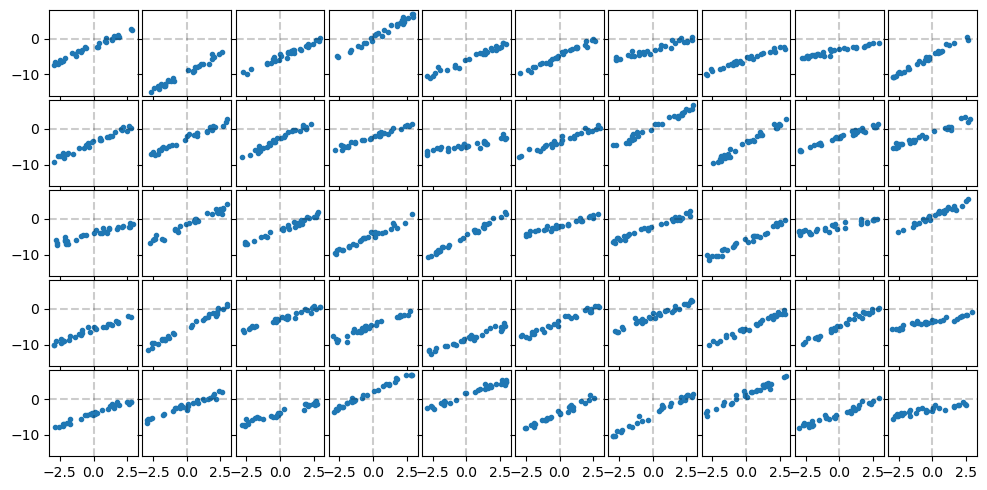

In [5]:
_ = plot_data(data)

## Define a probabilistic model in `numpyro` to fit this data

In [6]:
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

/Users/yhra/miniconda3/envs/BATIP/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def model(data):
    # define priors on mu_m, tau_m, mu_c, tau_c
    prior_mu_m = dist.Normal(0, 3)
    prior_tau_m = dist.HalfNormal(3)
    prior_mu_c = dist.Normal(0, 3)
    prior_tau_c = dist.HalfNormal(3)
    # sample mu_m, tau_m, mu_c, tau_c from their priors
    mu_m = numpyro.sample('mu_m', prior_mu_m)
    tau_m = numpyro.sample('tau_m', prior_tau_m)
    mu_c = numpyro.sample('mu_c', prior_mu_c)
    tau_c = numpyro.sample('tau_c', prior_tau_c)
    with numpyro.plate('N', data['N']):
        m = numpyro.sample('m', dist.Normal(mu_m, tau_m))
        c = numpyro.sample('c', dist.Normal(mu_c, tau_c))
        with numpyro.plate('n_dat', data['n_dat']):
            # sample the data
            y_obs = numpyro.sample(
                'y_obs',
                dist.Normal(m*data['x']+c, data['sig_y']),
                obs=data['y_obs'])
    return

## Draw the Bayesian Network for this model

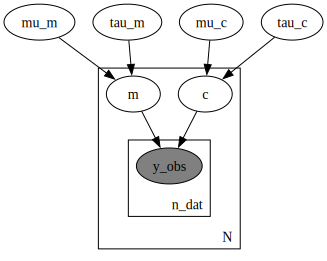

In [8]:
numpyro.render_model(model,  model_args=(data,))

## Run HMC/NUTS

This is a *gradient-based inference algorithm* for MCMC sampling.

In [9]:
# Start from this source of randomness
rng_key = random.PRNGKey(0)

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000)
mcmc.run(rng_key, data)

sample: 100%|██████████| 1500/1500 [00:01<00:00, 1456.21it/s, 15 steps of size 4.02e-01. acc. prob=0.88]


In [10]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      c[0]     -2.14      0.09     -2.14     -2.27     -2.00   2011.77      1.00
      c[1]     -9.38      0.09     -9.37     -9.52     -9.23   1957.30      1.00
      c[2]     -5.22      0.10     -5.22     -5.37     -5.05   1708.17      1.00
      c[3]      0.28      0.10      0.28      0.12      0.44   1723.92      1.00
      c[4]     -6.07      0.10     -6.07     -6.23     -5.91   1482.96      1.00
      c[5]     -4.74      0.09     -4.74     -4.88     -4.59   1509.84      1.00
      c[6]     -3.00      0.09     -3.00     -3.14     -2.85   2257.23      1.00
      c[7]     -5.85      0.09     -5.85     -6.00     -5.71   2226.38      1.00
      c[8]     -3.26      0.09     -3.26     -3.40     -3.10   1980.06      1.00
      c[9]     -4.72      0.10     -4.72     -4.90     -4.57   1499.43      1.00
     c[10]     -3.85      0.10     -3.85     -4.01     -3.69   2294.94      1.00
     c[11]     -2.75      0

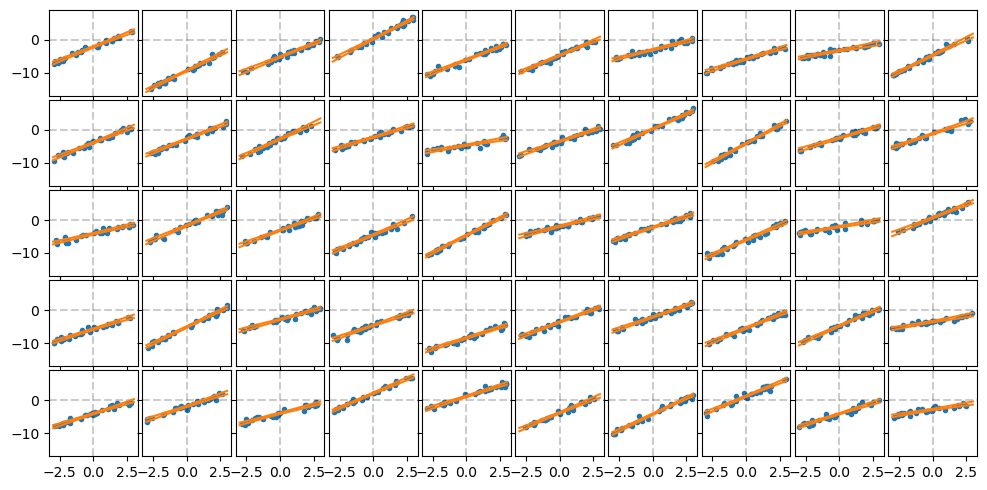

In [11]:
_ = plot_data(data, samples=mcmc.get_samples())

## Look at the posterior samples

In [12]:
import arviz as az

In [13]:
az_mcmc = az.from_numpyro(mcmc) 

In [14]:
az_mcmc

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

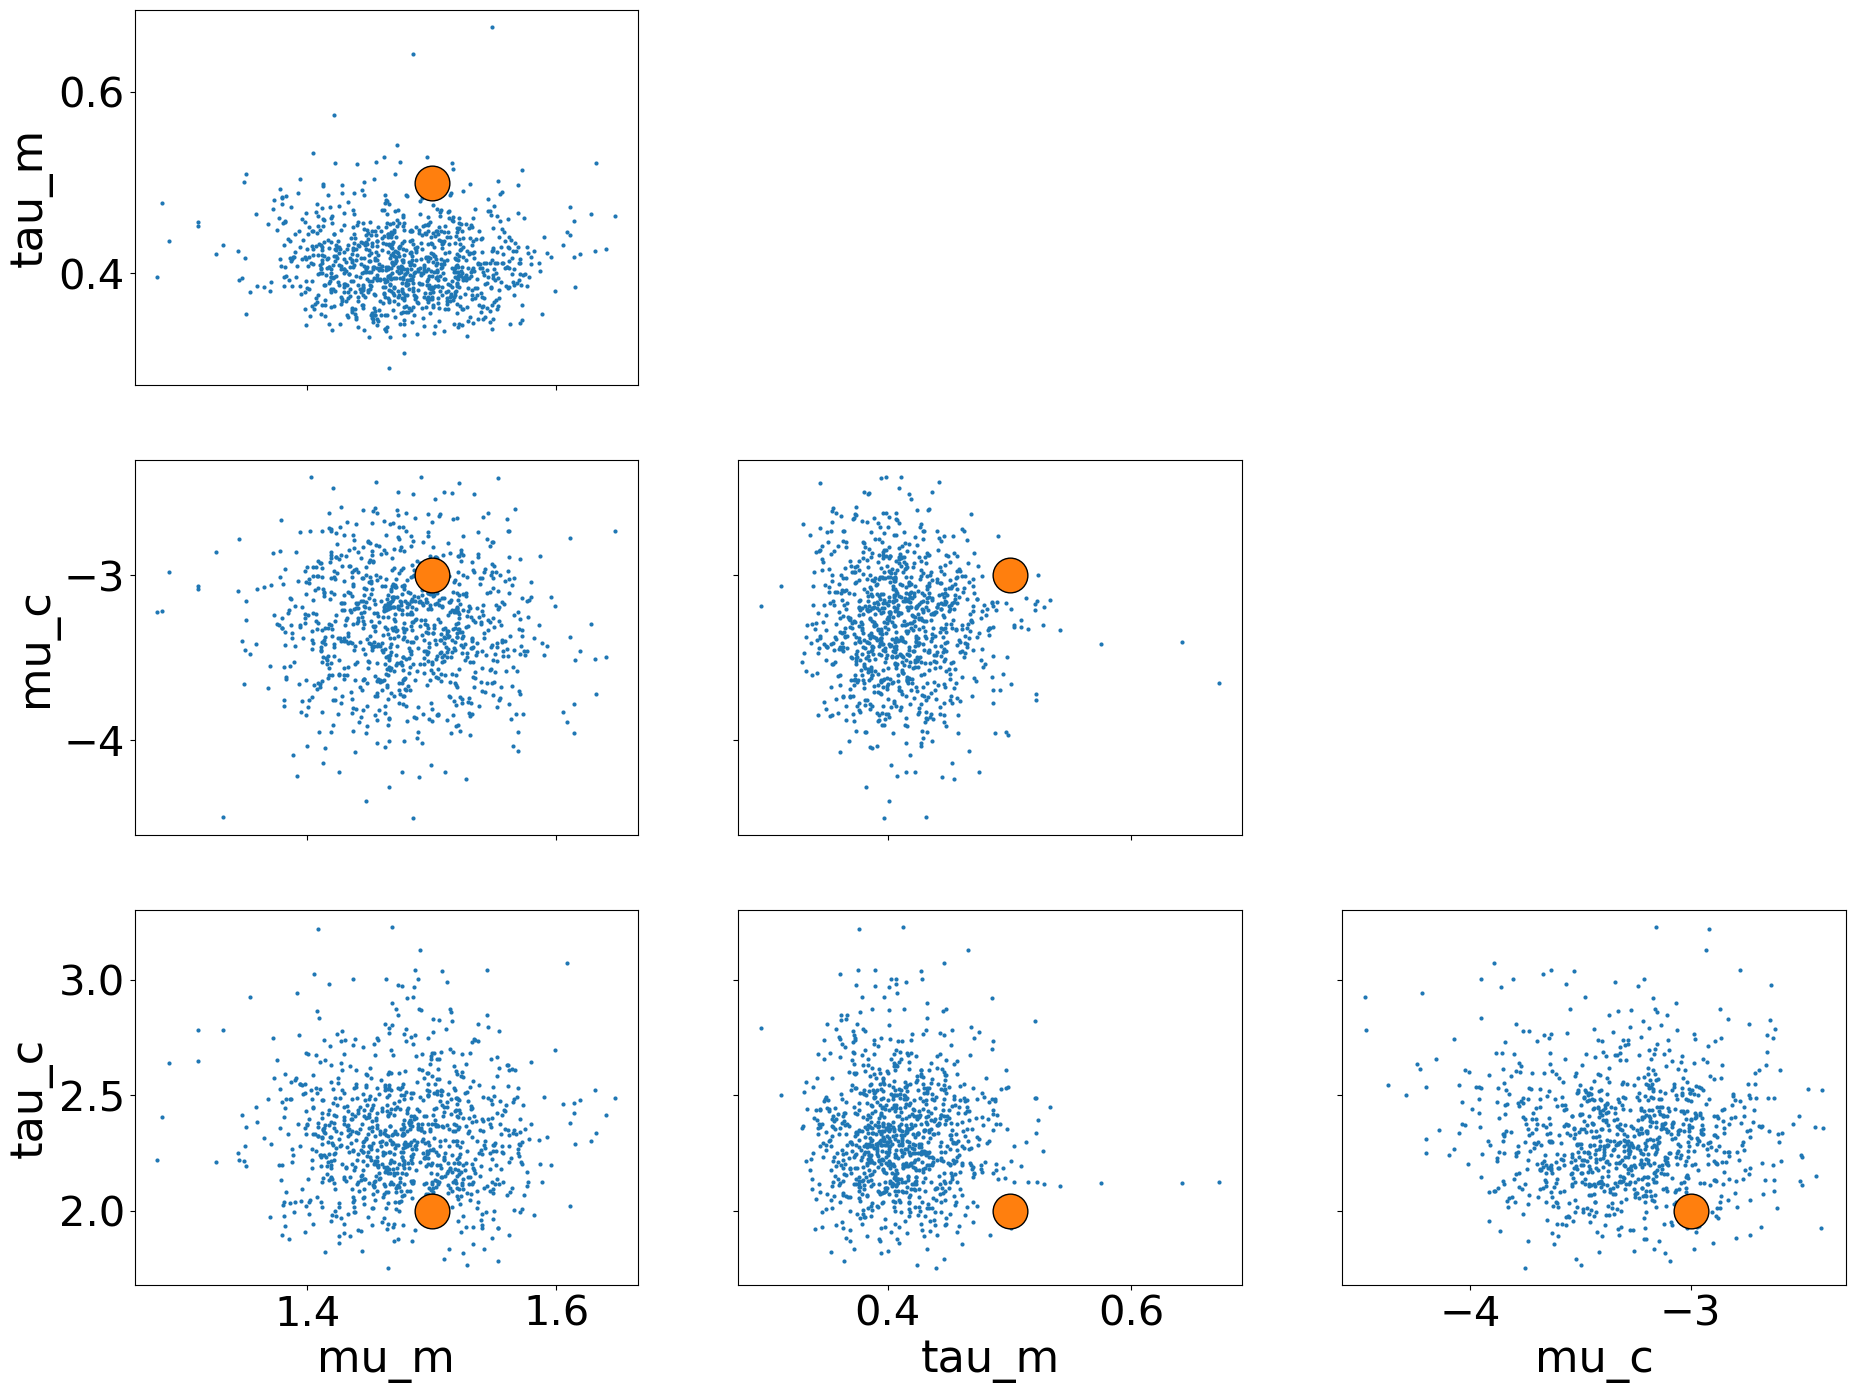

In [15]:
_ = az.plot_pair(
    az_mcmc,
    var_names=['mu_m', 'tau_m', 'mu_c', 'tau_c'],
    reference_values=true_pars,
    reference_values_kwargs={'color':'C1', 'markersize':25},
    textsize=30)

## Getting the target probability distribution

The `model` function implicitly defines a probability function which is used by the inference.

We can explictly get this function as follows,

In [16]:
from numpyro.infer.util import initialize_model
from jax import random

rng_key = random.PRNGKey(43)

param_info, potential_fn, postprocess_fn, *_ = initialize_model(
    rng_key,
    model,
    model_args=(data,),
    dynamic_args=True,
)

The `param_info` variable contains an intial position sampled from the prior distribution of unobserved variables.

In [17]:
# get initial position
initial_position = param_info.z
initial_position

{'mu_m': Array(0.3087225, dtype=float32),
 'tau_m': Array(0.7942662, dtype=float32),
 'mu_c': Array(-1.9236245, dtype=float32),
 'tau_c': Array(1.2005758, dtype=float32),
 'm': Array([-1.4505048 ,  0.5412388 , -1.7853746 , -0.8012781 , -0.7389035 ,
         0.87257767, -0.7987523 ,  1.8660121 , -1.1623139 , -1.51935   ,
        -1.1963744 ,  1.8898621 , -1.7840657 , -1.917419  ,  0.0689044 ,
        -0.3846674 ,  1.9633036 , -1.8559289 ,  0.6914277 ,  1.1436095 ,
        -0.04148102,  0.73496246,  0.48898792, -1.785326  , -1.7473688 ,
        -0.56143093,  0.878767  , -1.1534896 , -1.8843355 , -1.4754944 ,
         0.1219759 ,  1.0872998 , -1.8262548 ,  1.8090506 ,  1.9228563 ,
         0.52335215,  0.29183245, -1.7582722 ,  1.2698665 , -0.28751564,
         0.05380201, -0.441154  , -1.6053252 , -1.3704185 , -0.06970596,
         1.3366776 ,  1.8574567 ,  0.4843917 , -0.20385504,  1.2563629 ],      dtype=float32),
 'c': Array([ 0.74545527, -1.2697406 ,  0.375463  , -0.72902536,  0.6023

The `potential_fn` is the negative log of the target probability functions. We can get the log target probability density as follows,

In [18]:
def logdensity_fn(position):
    func = potential_fn(data)
    return -func(position)

In [19]:
logdensity_fn(initial_position)

Array(-90433.13, dtype=float32)

This returns a single number - this is the log of the target probability distribution. For running inference algorithms from numpyro you *don't need* to explicitly extract this target distribution function - everything is handled under-the-hood. 

Nevertheless, I think it is useful to see this to demystify what is happening. Also, this is useful if you want to [integrate `numpyro` models in other JAX-based inference libraries](https://num.pyro.ai/en/stable/tutorials/other_samplers.html).

## Other inference algorithms

Above, we ran an HMC/NUTS algorithm on our model.


### 1. Optimization to find the MAP solution

We'll use the optimizers from the [numpyro-ext](https://pypi.org/project/numpyro-ext/) library:

In [21]:
from numpyro_ext import optim as optimx
import numpyro.util as util


In [23]:
rng_key = random.key(43) 

map_soln = optimx.optimize(model)(rng_key, data)

In [24]:
map_soln

{'mu_m': Array(1.4775412, dtype=float32),
 'tau_m': Array(0.39361456, dtype=float32),
 'mu_c': Array(-3.308183, dtype=float32),
 'tau_c': Array(2.2338104, dtype=float32),
 'm': Array([1.6339412 , 2.0149438 , 1.6421975 , 2.098893  , 1.5988716 ,
        1.7409649 , 1.02273   , 1.2700446 , 0.7587112 , 2.0148869 ,
        1.6369655 , 1.6162187 , 1.8745021 , 1.2577227 , 0.67750543,
        1.3831751 , 1.8313417 , 2.2241054 , 1.2256333 , 1.3970236 ,
        0.956833  , 1.7084438 , 1.521216  , 1.7158576 , 2.0880363 ,
        1.0293851 , 1.3408631 , 1.8061548 , 0.68561196, 1.6384292 ,
        1.2992395 , 1.9928616 , 1.1590049 , 1.4110125 , 1.3066777 ,
        1.5276113 , 1.4299581 , 1.6540787 , 1.8052509 , 0.7157859 ,
        1.3247559 , 1.3913869 , 1.059276  , 1.7646079 , 1.3187879 ,
        1.7164513 , 1.9574349 , 1.697101  , 1.3103114 , 0.6529131 ],      dtype=float32),
 'c': Array([-2.1357925 , -9.37757   , -5.2185698 ,  0.27723357, -6.0692387 ,
        -4.7426505 , -3.0009906 , -5.852021 

Let's plot the results from the optimization on top of the MCMC samples from before. The orange dots are now the result from the optimization - not the true values as before.

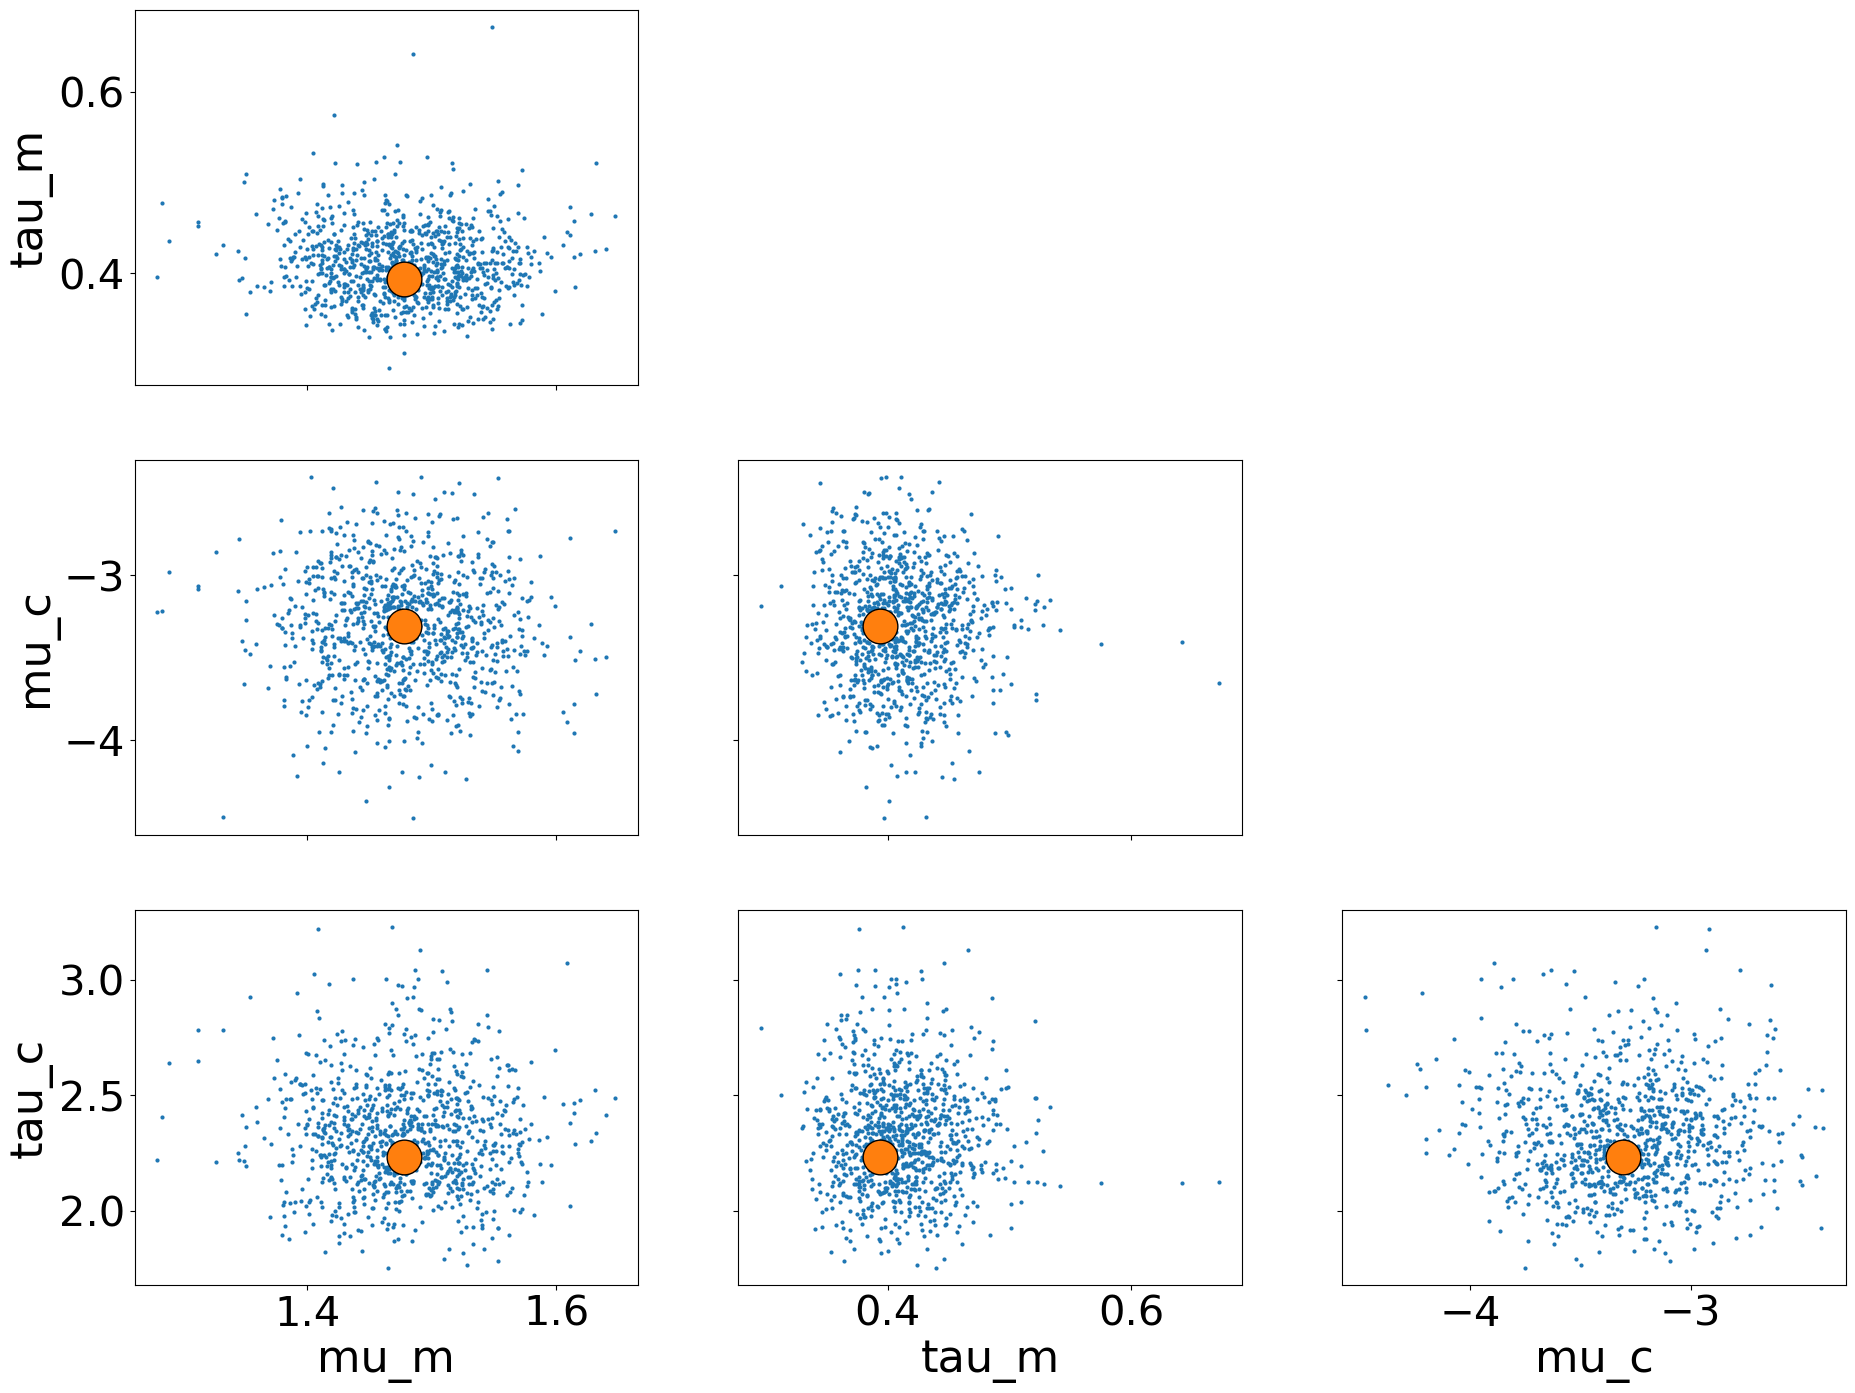

In [25]:
fig = az.plot_pair(
    az_mcmc,
    var_names=['mu_m', 'tau_m', 'mu_c', 'tau_c'],
    reference_values=map_soln,
    reference_values_kwargs={'color':'C1', 'markersize':25},
    textsize=30)

### 2. Calculating the Fisher Information Matrix

In [26]:
from numpyro_ext import information

In [27]:
help(information)

Help on function information in module numpyro_ext.info:

information(model, invert=False, include_prior=False, unconstrained=False)
    Compute the Fisher information matrix for a NumPyro model
    
    Note that this only supports a limited set of observation sites. By default,
    this requires either ``Normal`` or ``MultivariateNormal`` distributions for
    observed sites, but custom distributions can be supported by registering a
    custom ``standardize`` transformation. Take a look at the source code for
    ``numpyro_ext.info.standardize`` for some examples.
    
    Args:
        model: The NumPyro model definition.
        invert: If ``True``, the inverse information matrix will be returned.
        include_prior: If ``True``, the Hessian of the log prior will be
            subtracted from the information matrix.
        unconstrained: If ``True``, the parameters are assumed to be in the
            unconstrained space and the information is computed in that space.
    
   

In [28]:
# info = information(model)(map_soln, data)

There is a bug here! These types of broadcasting shapes errors are very common when using jax/numpyro. I will try to solve this by next time.

### 3. Variational Inference

We have to define the form of the guide distribution. `numpyro` offers two ways to do this:

- Define our own bespoke guide. See [numpyro documentation](https://num.pyro.ai/en/stable/svi.html) for an example.
- Use an [automatically generated guide](https://num.pyro.ai/en/stable/autoguide.html)

We'll use an automatically generated guide

In [29]:
from numpyro.infer import autoguide

In [30]:
guide = autoguide.AutoNormal(model)

We will optimize the parameters using Stochastic Variational Inference Algorithm (SVI). We define the loss (i.e. the quantity to minimize) to be the `Trace_ELBO`,

In [31]:
from numpyro.infer import SVI, Trace_ELBO
optimizer = numpyro.optim.Adam(step_size=0.001)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [32]:
n_steps_optimizer = 10000

svi_result = svi.run(rng_key, n_steps_optimizer, data)

100%|██████████| 10000/10000 [00:01<00:00, 5862.62it/s, init loss: 102839.7266, avg. loss [9501-10000]: 1470.3180]


At this stage, we have optimized the parameters of the guide. We can now draw samples from the guide distribution nd visualise these in a corner plot,

In [33]:
n_samples = 1000

posterior_samples_from_guide = guide.sample_posterior(
    rng_key,
    svi_result.params,
    sample_shape=(n_samples,)
)

Make a corner plot showing samples drawn from the variational guide i.e. not the MCMC samples.

/Users/yhra/miniconda3/envs/BATIP/lib/python3.10/site-packages/arviz/data/base.py:272: UserWarning: More chains (1000) than draws (50). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


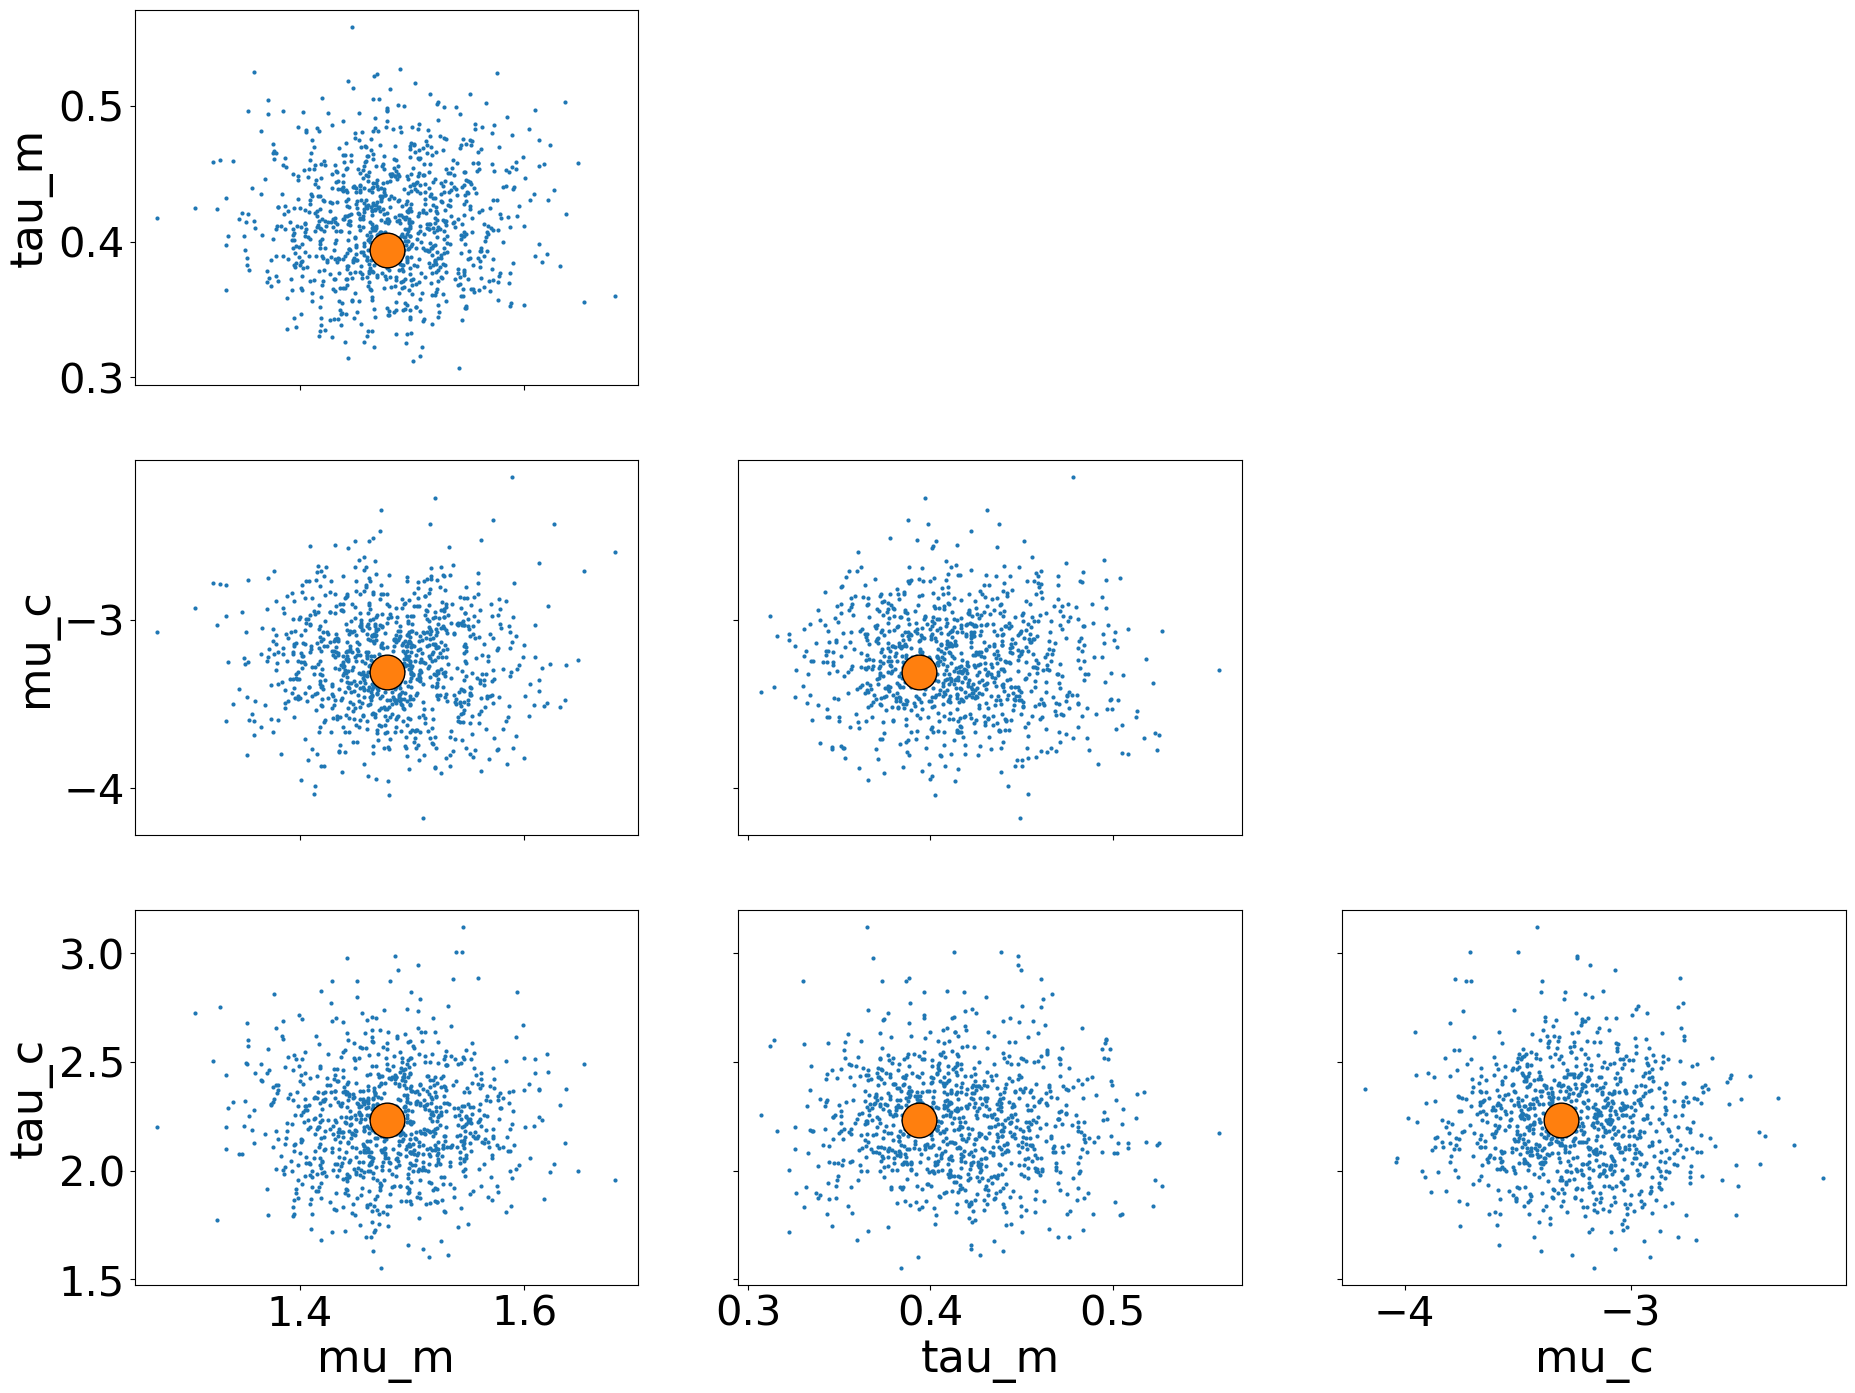

In [34]:
fig = az.plot_pair(
    posterior_samples_from_guide,
    var_names=['mu_m', 'tau_m', 'mu_c', 'tau_c'],
    reference_values=map_soln,
    reference_values_kwargs={'color':'C1', 'markersize':25},
    textsize=30)